# Implementacion de metodos numericos con el oscilador armónico simple


## Oscilador armónico
El oscilador armónico es uno de los sistemas más estudiados en la física, ya que todo sistema que oscila al rededor de un punto de equilibrio estable se puede estudiar en primera aproximación como si fuera un oscilador.
La característica principal de un oscilador armónico es que está sometido a una fuerza recuperadora, que tiende a devolverlo al punto de equilibrio estable, con una intensidad proporcional a la separación respecto de dicho punto,

$$F = -k(x-x_0)$$

donde $k$ es la constante de recuperación, y $x_0$ es la posición de equilibrio, que sin pérdida de generalidad podemos tomar $ x_0 = 0$.

## Oscilador armónico simple

El oscilador armónico simple es el caso más sencillo, donde únicamente se considera la fuerza recuperadora. Teniendo en cuenta que $ F = m a = m \frac{\mathrm{d}^2 x}{\mathrm{d}t^2}$ , la ecuación $F = -k(x-x_0)$ nos da la siguiente ecuación diferencial

$$\frac{\mathrm{d}^2 x}{\mathrm{d}t^2} + \omega_0^2 x = 0 \ $$
donde los puntos indican derivación respecto del tiempo, y $ \omega_0^2 = \sqrt{k/m}$ es la frecuencia natural de vibración. La solución general a esta ecuación se puede escribir de la forma
$$x(t) = A \cos \left( \omega_o t + \varphi_0 \right) \ $$


donde A y $ \varphi_0$ se obtienen imponiendo las condiciones iniciales

Para dar un ejemplo de una solucion particular de l ecuacion particular usare el metodo de RK4 en su forma vectorial ya que estamos tratando con una ecuacion diferencial de segundo orden.

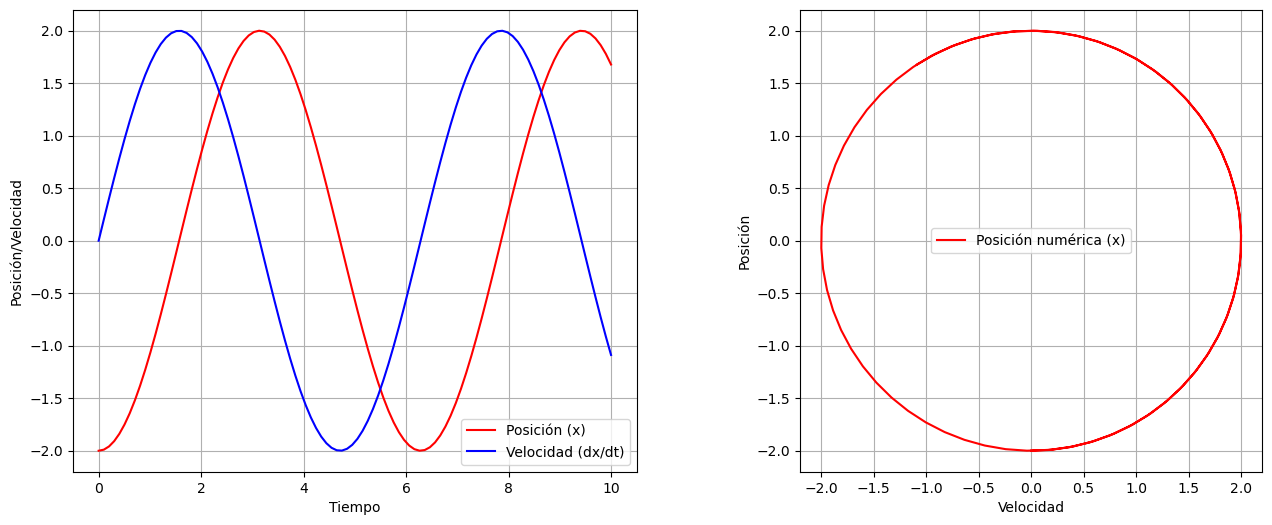

In [24]:
import numpy as np
import Bloque_1 as blo
import matplotlib.pyplot as plt

def fs(x, yvals):
    omega_0 = 1  
    fx = yvals[1]
    fy = -omega_0**2 * yvals[0]
    return np.array([fx, fy])

yinits = np.array([-2, 0], dtype=np.float64) 
n = 100
ts, ys = blo.rk4_vec(fs, 0, 10, n, yinits, 2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].plot(ts, ys[:, 0], c='red', label='Posición (x)')
ax[0].plot(ts, ys[:, 1], c='blue', label='Velocidad (dx/dt)')
ax[0].set_xlabel('Tiempo')
ax[0].set_ylabel('Posición/Velocidad')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(ys[:, 1], ys[:, 0], c='red', label='Posición numérica (x)')
ax[1].set_xlabel('Velocidad')
ax[1].set_ylabel('Posición')
ax[1].legend()
ax[1].grid(True)
ax[1].set_aspect('equal', adjustable='box')

plt.show()

## Obtencion de datos

Para la implementacion de los metodos numericos apartir de la teoria dada se tuvo que implementar un experimento que tuviera una buena aproximacion de los modelos teoricos que vamos a analizar, se utlizo el siguiente mecanismo:

<center><img src="mecanismo.png" width="250" height="175"></center> 

Consta de una fuente de luz que proyecta ls sombra horizontal de una esfera sujeta a un disco que gira a una frecuencia constante por medio de un moto de 3v, la sombra se proyecta sobre un plano donde se han colocado 5 fotoresistencias(sensores de luz) equidistantes, dichos dispositivos mandaran una senal a un dispositivo arduino UNO que registrara dos listas, una de posicion y otra de tiempo. Los datos registrados por el dispositivo es posible tratarlo por la forma en la que se realizo una conexion entre arduino y python, un ejemplo de ello a continuacion:r

In [ ]:
import serial
import time
import numpy as np

ser = serial.Serial('COM5', 9600, timeout=1)
time.sleep(2)

photoresistorDetections = []
detectionTimes = []

try:
    while True:
        if ser.in_waiting > 0:
            line = ser.readline().decode('utf-8').strip()
            if line == "Detecciones completadas:":
                ser.readline()
                for _ in range(50):
                    data_line = ser.readline().decode('utf-8').strip()
                    if data_line:
                        photoresistor, time_ms = data_line.split('\t\t')
                        photoresistorDetections.append(int(photoresistor))
                        detectionTimes.append(int(time_ms))
                break
finally:
    ser.close()

t = np.array(detectionTimes)
y_raw = np.array(photoresistorDetections)

Por falta de una mejor logistica y para mejorar la presentacion se usaran datos ya extraidos de una prueba con el mecanismo, la tanda de datos seleccionada es casi ideal, fue seleccionada entre unas pocas decenas de pruebas.

## Interpolacion

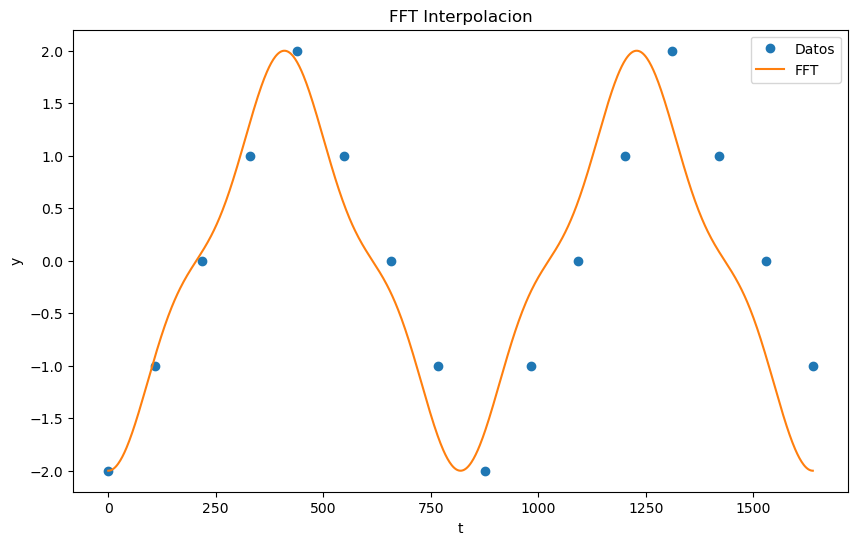

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Bloque_1 as blo
import sympy as sym

t = np.array([0, 109, 218, 329, 438, 548, 657, 766, 875, 984, 1093, 1202,
              1311, 1420, 1529, 1638])
y = np.array([-2, -1,  0,  1,  2,  1,  0, -1, -2, -1,  0,  1,  2,  1,
                  0, -1])
ytils = blo.fft(y)

t_interp = np.linspace(t[0], t[-1], 1000)
y_interp = np.array([blo.fftinterp(ytils, i * 2 * np.pi / t[-1]) for i in t_interp])

plt.figure(figsize=(10, 6))
plt.plot(t, y, 'o', label='Datos')
plt.plot(t_interp, y_interp.real, '-', label='FFT')
plt.xlabel('t')
plt.ylabel('y')
plt.title('FFT Interpolacion')
plt.legend()

Text(0, 0.5, 'y')

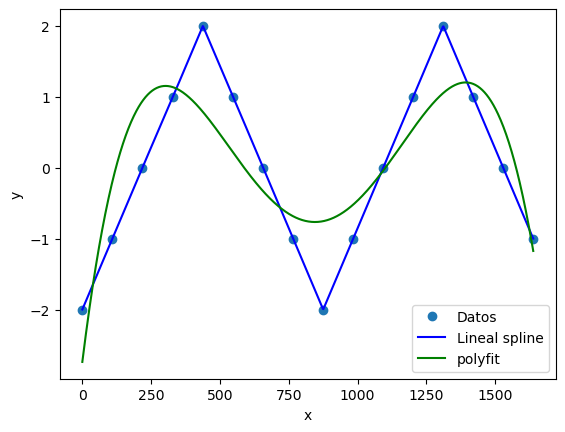

In [4]:
lagrange, expresion = blo.lege_interpol(t, y)
polyfit = np.polyfit(t, y, 4)
polyfit = np.poly1d(polyfit)

xi = np.linspace(t[0], t[-1], 1000)
yi = np.array([blo.linear_spline_interpolation(t, y, i) for i in xi])
plt.plot(t, y,'o', label = 'Datos')
#plt.plot(xi, lagrange(xi), 'r:', label = 'Lagrange')
plt.plot(xi, yi, 'b', label = 'Lineal spline')
plt.plot(xi, polyfit(xi), 'g-', label = 'polyfit')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')

## Fitting. Regresión No lineal de los Mínimos al cuadrado (Non-Linear Least-Squares Fitting)

El mejor ajuste es:  [-3090.31822064    11.09937627    18.03193268]
curve_fit:  [1.7124492  0.00720396 3.129149  ]


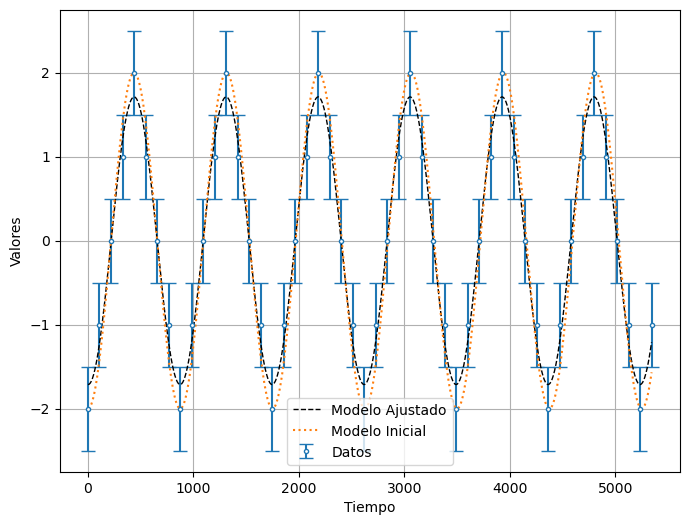

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import Bloque_1 as blo
from scipy.optimize import curve_fit

t = np.array([0, 109, 218, 329, 438, 548, 657, 766, 875, 984, 1093, 1202,
              1311, 1420, 1529, 1638, 1747, 1856, 1965, 2074, 2183, 2292,
              2401, 2510, 2619, 2728, 2837, 2946, 3055, 3164, 3273, 3382,
              3491, 3600, 3709, 3818, 3927, 4036, 4145, 4254, 4363, 4472,
              4581, 4690, 4799, 4908, 5017, 5126, 5235, 5344])
y_raw = np.array([-2, -1,  0,  1,  2,  1,  0, -1, -2, -1,  0,  1,  2,  1,
                  0, -1, -2, -1,  0,  1,  2,  1,  0, -1, -2, -1,  0,  1, 
                  2,  1,  0, -1, -2, -1, 0,  1,  2,  1,  0, -1, -2, -1,
                  0,  1,  2,  1,  0, -1, -2, -1])
y = y_raw

def gdata():
  data = np.zeros((3,50))
  data[0,:] = t
  data[1,:] = y
  data[2,:] = 0.5*np.ones(data.shape[1])
  
  return data

def model(cs, xi):
  p = cs[0]* np.cos(cs[1]*xi + cs[2]) 
  return p
def cos_model(t, A, omega, mu):
    return A * np.cos(omega * t + mu)
    
ckm1 = np.array([2, 0.00718, np.pi]) #2 * np.pi / np.mean(np.diff(t)), 0.00718, -np.pi/2
data = gdata()

ck = blo.gaussnewton(data, ckm1, tol=1.e-05)
print('El mejor ajuste es: ', ck)

params, params_covariance = curve_fit(cos_model, t, y, p0=ckm1)
print('curve_fit: ', params)

xval = np.linspace(data[0][0], data[0][-1], 500)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.errorbar(data[0], data[1], yerr=data[2], capsize=5, ls='', marker='o', mfc='white', ms=3, mew=1, label='Datos')
#ax.plot(xval, model(ck, xval), ls='--', lw=1, c='k', label='Modelo Ajustado')
ax.plot(xval, model(params, xval), ls='--', lw=1, c='k', label='Modelo Ajustado')
ax.plot(xval, model(ckm1, xval), ls=':', label='Modelo Inicial')

ax.set_xlabel('Tiempo')
ax.set_ylabel('Valores')
ax.legend()
ax.grid(True)

## Integracion y derivacion en base a un modelo ideal

Tomando en cuenta:
$$x(t) = A \cos \left( \omega_o t + \varphi_0 \right) \ $$ 
Podemos elegir coeficientes ideales para una ecuacion cuyas derivadas e integrales en intervalos y puntos especificos den como resultado valores caracteristicos de una ecuacion de onda. Por ejemlo muy similar a los coeficientes esperados en la experimentacion:
$$x(t) = 2 \cos \left( t + \pi \right) \ $$
Cuya grafica corresponde a:

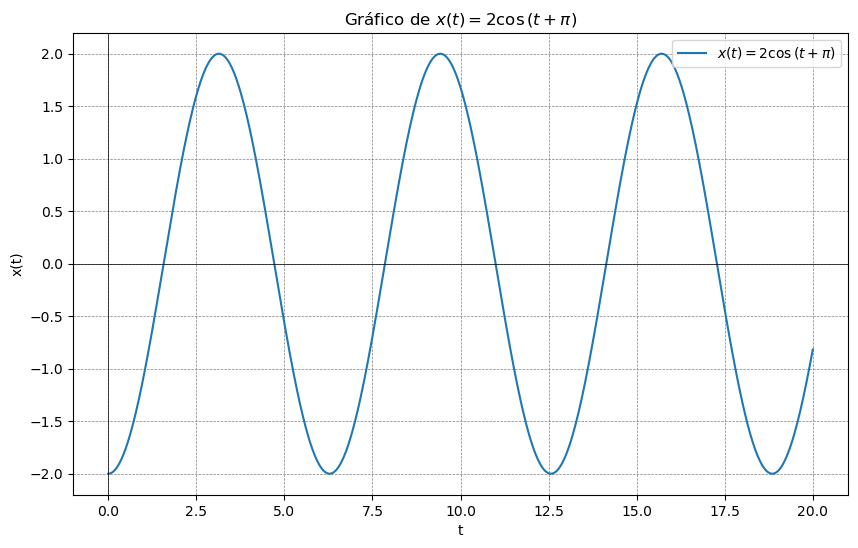

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import Bloque_1 as blo

def x(t):
    return 2 * np.cos(t + np.pi)

t_values = np.linspace(0, 20, 1000)
x_values = x(t_values)

plt.figure(figsize=(10, 6))
plt.plot(t_values, x_values, label=r'$x(t) = 2 \cos \left( t + \pi \right)$')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title(r'Gráfico de $x(t) = 2 \cos \left( t + \pi \right)$')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.legend()

### Derivacion
Con respecto a las funciones del tipo coseno y seno podriamos esperar que en sus maximos y minimos su derivada sea igual a 0, vamos a aprovecharnos de este hecho para verificar la funcion de nuestro codigo para el calculo de derivadas. Como se sabe, los minimos y maximos en la funcion coseno los podemos encontrar en los puntos descritos por $N\pi$ siendo $N$ un numero entero.

In [14]:
import numpy as np
import Bloque_1 as blo
import random

def x(t):
    return 2 * np.cos(t + np.pi)
    
NR = random.randint(-50, 50)
print(f"Número entero aleatorio: {NR}")

dif_cent = blo.dif_central(x, NR*np.pi)
dif_cent_4to = blo.dif_central_4to(x, NR*np.pi)
dif_der = blo.dif_derecha(x, NR*np.pi)
dif_izq = blo.dif_izquierda(x, NR*np.pi)

Número entero aleatorio: -5
Derivada central de 2do orden aproximada: 0.0
Derivada central de 4to orden aproximada: 0.0
Derivada derecha aproximada: -1.000000082740371e-05
Derivada izquierda aproximada: 1.000000082740371e-05


Como podemos notar sin importar el numero entero que se use el resultado siempre debe ser cero o cercano a 0 en el caso de los metodos con mayor error.
Por lo dicho anteriormente sabemos que ese cero representa un maximo o un minimo pero podes distinguir uno del otro atraves de la segunda derivada.
Si la segunda derivada es positiva ($f''(x) > 0$), la función es cóncava hacia arriba en ese punto. Si la segunda derivada es negativa ($f''(x) < 0$), la función es cóncava hacia abajo en ese punto.


In [15]:
seg_dif_cen = blo.segunda_dif_central(x, NR*np.pi)


Segunda derivada central aproximada: -0.5000000413701854


### Integracion
Por la teoria sabemos que la integral de una funcion coseno se cancela en cierto intervalo, para este caso en particular sabemos que podemos generalizar estos intervalos como $[a , a + 2N\pi]$, nuevamente tomand $N$ como un numero entero positivo y a cualquier numero real.

In [3]:
import numpy as np
import Bloque_1 as blo
import random

def x(t):
    return 2 * np.cos(t + np.pi)

A = random.uniform(-50, 50)
N = random.randint(int(A), 100)
print(f"Número entero aleatorio: {N}")
print(f"Número real aleatorio: {A}")
print(f" ")
B = A + 2*N*np.pi

print('Metodo del rectangulo')
rect = blo.integracion_rect(x, A , B)
print('Metodo del rectangulo centralizado')
rect_cen = blo.integracion_rect_cen(x, A , B)
print('Metodo del trapecio')
trap = blo.integracion_trap(x, A , B)
print('Metodo del simpson 1/3')
simpson_1_3 = blo.integracion_simpson_1_3(x, A , B)
print('Metodo del simpson 3/8')
simpson_3_8 = blo.integracion_simpson_3_8(x, A , B)
print('Metodo de boole')
boole = blo.integracion_boole(x, A , B)

Número entero aleatorio: 98
Número real aleatorio: 26.784276976719738
 
Metodo del rectangulo
La integral da como resultado: 
6.9819705572626845e-12
Metodo del rectangulo centralizado
La integral da como resultado: 
-2.332356530132529e-12
Metodo del trapecio
La integral da como resultado: 
6.578793065870059e-12
Metodo del simpson 1/3
La integral da como resultado: 
7.785216915578985e-12
Metodo del simpson 3/8
La integral da como resultado: 
1.236510893676268e-12
Metodo de boole
La integral da como resultado: 
8.0237483324197e-12


# Raíces

Nuevamente haremos uso de la ecuacion:
$$x(t) = 2 \cos \left( t + \pi \right) \ $$
De la parte teorica y de la grafica sabemos que los ceros de la ecuacion son periodicos y de forma general los encontrariamos en $t = (\pi/2) (2k-1)$ teniendo como $k$ cualquier numero entero, utilizando los codigos creados se espera encontrar las raices en dichos puntos.

In [16]:
import numpy as np

k = [1., 2., 3., 4.]
for i in range(len(k)):
    k[i] = (np.pi/2)*(2*k[i]-1)
print(k)

[1.5707963267948966, 4.71238898038469, 7.853981633974483, 10.995574287564276]


In [1]:
import numpy as np
import Bloque_1 as blo

def f(t):
    return 2 * np.cos(t + np.pi)

def fp(t):
    return 2 * np.sin(t)
    
metodo_bis = blo.metodo_biseccion(f, 0, 11)
metodo_new = blo.metodo_newton_v2(f, fp, 0, 11)

La raíz aproximada es: 1.57080078125
La raíz aproximada es: 4.71239013671875
La raíz aproximada es: 7.853979492187488
La raíz aproximada es: 7.853985109925258
La raíz aproximada es: 10.995574951171852
Fin del programa
Raíz encontrada: 1.5707963267948963
Raíz encontrada: 4.71238898038469
Raíz encontrada: 7.853981633974483
Raíz encontrada: 10.995574287564276


## Fuente utilizada:
### [lawebdefisica](https://www.lawebdefisica.com/dicc/oscil/)
